# Air Pollution Dataset Preprocessing

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

from utils import *

datasets_folder = './datasets'

## Data Reading

In [3]:
air_pollution_dataset = os.path.join(datasets_folder,'pollution/pollution.csv')

air_pollution_df = pd.read_csv(air_pollution_dataset, sep=';')
air_pollution_df.rename(columns={
    'COD_STAZ': 'Station', 
    'AGENTE': 'Agent', 
    'DATA_INIZIO': 'Date', 
    'DATA_FINE': 'Ending_date', 
    'VALORE': 'Value', 
    'UM': 'Unit'
}, inplace=True)

air_pollution_df.drop(columns=['Ending_date'], inplace=True)
air_pollution_df=air_pollution_df.sort_values(by='Date')
air_pollution_df['Date'] = pd.to_datetime(air_pollution_df['Date'].apply(lambda x: ' '.join(x.split('T')).split('+')[0]))
air_pollution_df['Agent'] = air_pollution_df['Agent'].apply(lambda x: x.split(' ')[0])

air_pollution_df.head(3)

,Station,Agent,Date,Value,Unit
6726,GIARDINI MARGHERITA,PM2.5,2019-01-01 00:01:00,37.0,ug/m3
8067,GIARDINI MARGHERITA,PM10,2019-01-01 00:01:00,50.0,ug/m3
419631,PORTA SAN FELICE,PM2.5,2019-01-01 00:01:00,41.0,ug/m3


Let's check the Unit of each agent

In [4]:
air_pollution_df.groupby([ 'Agent','Unit']).size().reset_index(name='counts').drop(columns='counts')

,Agent,Unit
0,C6H6,ug/m3
1,CO,mg/m3
2,NO,ug/m3
3,NO2,ug/m3
4,NOX,ug/m3
5,O3,ug/m3
6,PM10,ug/m3
7,PM2.5,ug/m3


In [5]:
agents = np.unique(air_pollution_df['Agent'])
stations = np.unique(air_pollution_df['Station'])

station_dfs = {s:air_pollution_df[air_pollution_df['Station'] == s] for s in stations}

## Missing Values


Check gaps in the data

In [6]:
s=stations[0]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station GIARDINI MARGHERITA:
 - Agent: NO2


Date,1.0,2.0,3.0,9.0,0.0,5.0,18.0,4.0,43.0,28.0,...,77.0,50.0,16.0,12.0,11.0,10.0,19.0,8.0,7.0,24.0
count,50984,449,23,4,3,3,2,2,2,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: O3


Date,1.0,2.0,3.0,4.0,0.0,49.0,8.0,7.0,18.0,10.0,...,17.0,53.0,11.0,84.0,47.0,25.0,51.0,19.0,31.0,43.0
count,51555,134,20,6,6,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,23.0,25.0,48.0,72.0,96.0,144.0,120.0,192.0
count,2038,12,12,12,11,9,3,2,1


 - Agent: PM2.5


Date,24.0,48.0,23.0,25.0,72.0,96.0,0.0,144.0,120.0
count,2071,13,12,12,6,6,5,3,2


In [7]:
s=stations[1]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station PORTA SAN FELICE:
 - Agent: C6H6


Date,1.0,2.0,3.0,4.0,0.0,5.0,25.0,39.0,9.0,8.0,...,22.0,27.0,17.0,97.0,81.0,48.0,43.0,23.0,40.0,20.0
count,46760,1911,193,17,4,4,3,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: CO


Date,1.0,2.0,3.0,4.0,0.0,6.0,5.0,8.0,14.0,15.0,...,34.0,17.0,42.0,47.0,11.0,7.0,75.0,22.0,170.0,23.0
count,51678,53,23,5,4,4,3,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NO


Date,1.0,2.0,3.0,4.0,6.0,0.0,5.0,24.0,23.0,19.0,...,15.0,8.0,42.0,7.0,11.0,48.0,18.0,34.0,89.0,16.0
count,51072,410,30,8,7,5,4,3,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NO2


Date,1.0,2.0,3.0,4.0,5.0,0.0,6.0,14.0,24.0,25.0,...,37.0,15.0,48.0,42.0,18.0,34.0,19.0,23.0,89.0,12.0
count,51070,409,30,8,6,5,5,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NOX


Date,1.0,2.0,3.0,4.0,6.0,0.0,5.0,24.0,15.0,8.0,...,7.0,11.0,18.0,48.0,42.0,34.0,19.0,23.0,89.0,37.0
count,51197,407,31,8,5,5,4,2,1,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,23.0,25.0,48.0,72.0,96.0,144.0,120.0
count,2093,12,12,8,7,5,2,1


 - Agent: PM2.5


Date,24.0,23.0,25.0,48.0,72.0,96.0,120.0,144.0,0.0
count,2094,12,12,11,8,4,1,1,1


In [8]:
s=stations[2]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station VIA CHIARINI:
 - Agent: NO2


Date,1.0,2.0,3.0,4.0,0.0,5.0,7.0,8.0,6.0,12.0,25.0,10.0,21.0,17.0,26.0,31.0,30.0,70.0,39.0,15.0
count,51121,470,28,9,8,6,3,3,3,2,2,1,1,1,1,1,1,1,1,1


 - Agent: O3


Date,1.0,2.0,3.0,4.0,0.0,5.0,8.0,6.0,14.0,7.0,...,28.0,17.0,26.0,13.0,9.0,30.0,70.0,23.0,12.0,25.0
count,51117,386,16,8,6,4,3,2,2,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,48.0,23.0,25.0,72.0,96.0,192.0,120.0,144.0,168.0
count,2065,16,12,12,5,4,2,2,1,1


### Resampling

Resample (modify dataframe to have a dense index and add also to each row the missing values for station and Unit(not really necessary anyway))
PM are resampled at 24h, other agents at 1h

In [9]:
agents_dict = {
    'PM10': '24h',
    'PM2.5': '24h',
    'CO': '1h',
    'O3': '1h',
    'NO': '1h',
    'NO2': '1h',
    'NOX': '1h',
    'C6H6': '1h'
}

resampled_san_felice_df = resample_df_on_column(station_dfs[stations[1]], agents_dict)
resampled_san_felice_df[resampled_san_felice_df['Agent'] == 'NO2'].head()


Resampling for station "PORTA SAN FELICE..."


,Date,Station,Agent,Value,Unit
0,2019-01-01 00:00:00,PORTA SAN FELICE,NO2,40.0,ug/m3
1,2019-01-01 01:00:00,PORTA SAN FELICE,NO2,36.0,ug/m3
2,2019-01-01 02:00:00,PORTA SAN FELICE,NO2,34.0,ug/m3
3,2019-01-01 03:00:00,PORTA SAN FELICE,NO2,NaN,ug/m3
4,2019-01-01 04:00:00,PORTA SAN FELICE,NO2,39.0,ug/m3


Added the missing rows but still the value is Nan

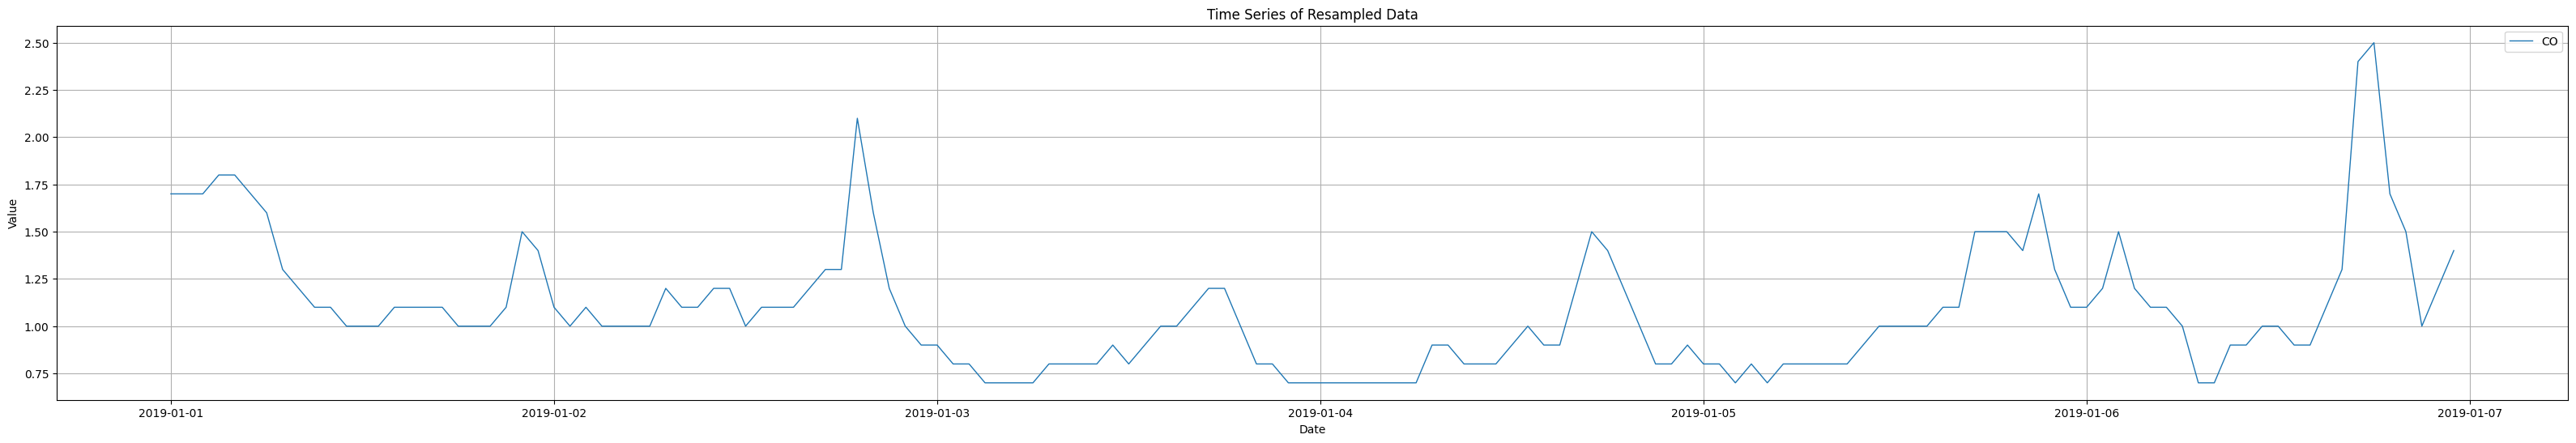

In [14]:
start_date=datetime(2019,1,1)
end_date=datetime(2019,1,7)

to_plot = resampled_san_felice_df[resampled_san_felice_df['Agent']=='CO']

# plot_time_series([giardini_df[giardini_df['Agent']=='CO']], 'Value', 'Date', legends=['CO'], start_date=start_date, end_date=end_date, title='Original Data')
plot_time_series([to_plot], 'Value', 'Date', legends=['CO'], start_date=start_date, end_date=end_date, title='Resampled Data')

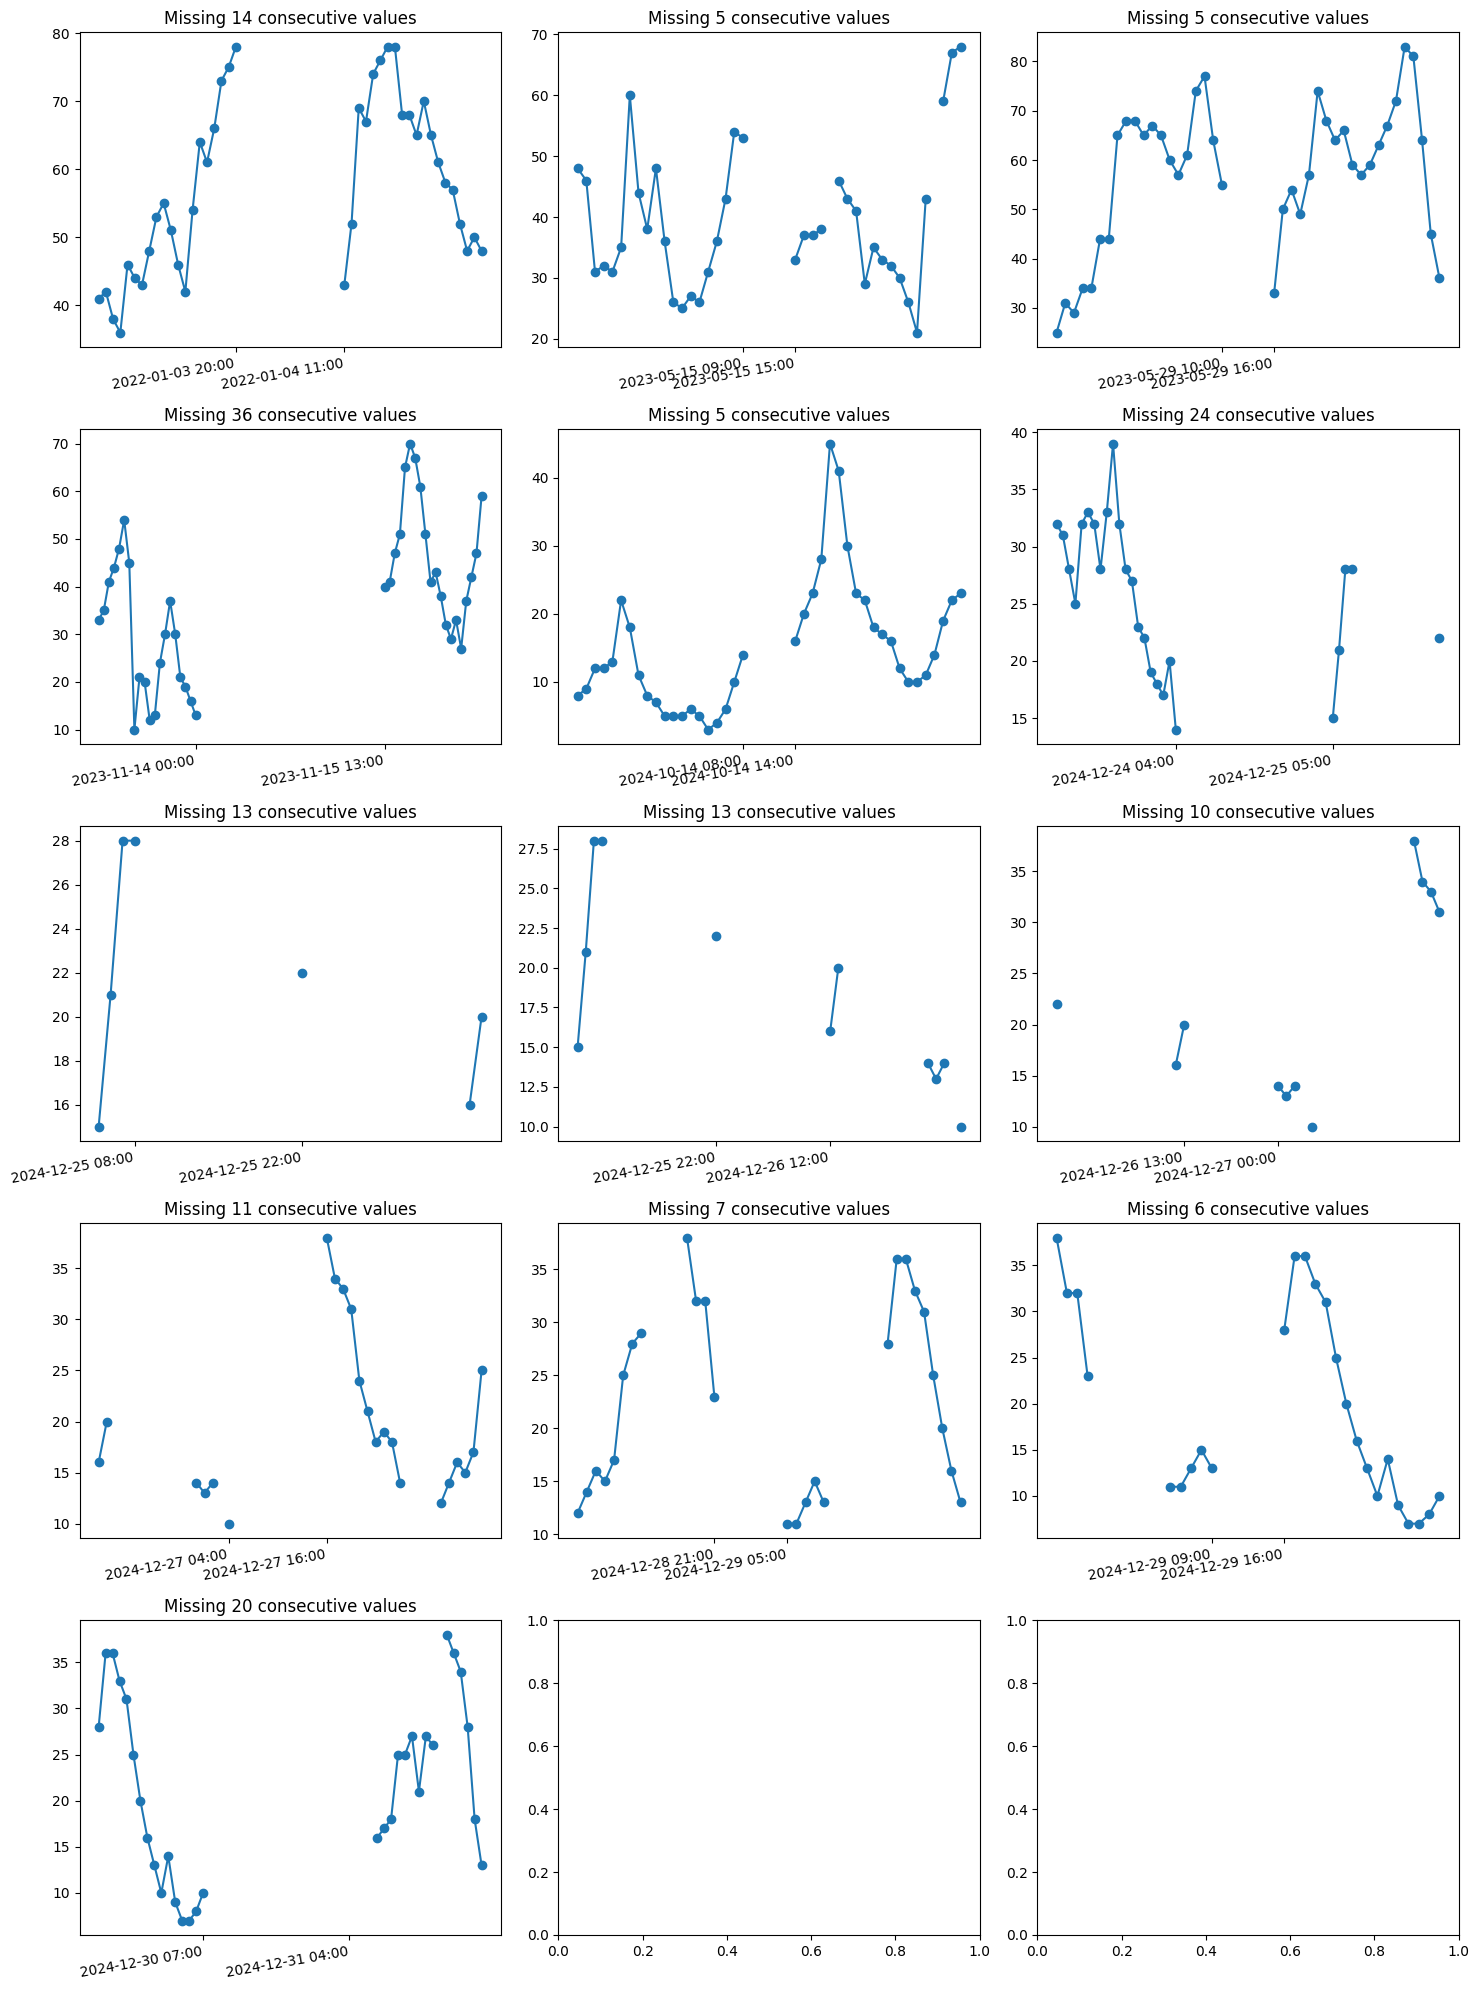

In [ ]:
start_date=datetime(202 2,1,1)
end_date=datetime(2025,1,1)

# display the gaps of at lest 5 hours of NO2
plot_missing_value_gaps(to_plot,start_date=start_date, end_date=end_date,
                         min_gap=5, surrounding_vals=20)

Check the amount of missing data for each agent.

In [12]:
for agent in np.unique(resampled_san_felice_df['Agent']):
    count = resampled_san_felice_df[resampled_san_felice_df['Agent']==agent].isna().sum()['Value']
    tot = len(resampled_san_felice_df[resampled_san_felice_df['Agent']==agent])
    print(f'Agent {agent}: {count}({count/tot:.4f}%) missing Values')

Agent C6H6: 3675(0.0699%) missing Values
Agent CO: 821(0.0156%) missing Values
Agent NO: 1056(0.0201%) missing Values
Agent NO2: 1056(0.0201%) missing Values
Agent NOX: 940(0.0179%) missing Values
Agent PM10: 57(0.0260%) missing Values
Agent PM2.5: 54(0.0246%) missing Values


## Filling Missing Values

Even if the data missing is small, oftentimes they create a big gap of missing values. We will try to reconstruct it to a somewhat reasonable behaviour.

### Full Process

For each agent, we train a model to reconstruct the missing values.

#### Time Period

the prof had 5 min sampling and used 8 days... we have 60 minutes so... 3 months (?)

Looking at the plots, most of 2023 and 2024 havent got big gaps, but also early 2019/2023 and late 2022. Let's try november 2022 to february 2023.

Edit: mi sa non bastano?? allungo un po


In [77]:
start = datetime(2022,4,5,8)
end = datetime(2022,6,30)
end-start

datetime.timedelta(days=85, seconds=57600)

We are going to work with NO2 data.

In [78]:
resampled_giardini_df['Date_idx'] = np.arange(len(resampled_giardini_df))

In [79]:
segment = resampled_giardini_df[(resampled_giardini_df['Agent']=='NO2')&(resampled_giardini_df['Date']>=start)&(resampled_giardini_df['Date']<end)]
display(segment.isna().sum())
# display(segment)

Date         0
Station      0
Agent        0
Value       24
Unit         0
Date_idx     0
dtype: int64

#### Train and Test set

The segment has only 4 missing values, so we choose a good period... Let's drop these rows and prepare a training and test set.

In [80]:
tmp = segment.copy()
tmp = tmp.dropna()
tmp

,Date,Station,Agent,Value,Unit,Date_idx
28568,2022-04-05 08:00:00,GIARDINI MARGHERITA,NO2,10.0,ug/m3,28568
28569,2022-04-05 09:00:00,GIARDINI MARGHERITA,NO2,7.0,ug/m3,28569
28570,2022-04-05 10:00:00,GIARDINI MARGHERITA,NO2,10.0,ug/m3,28570
28571,2022-04-05 11:00:00,GIARDINI MARGHERITA,NO2,12.0,ug/m3,28571
28572,2022-04-05 12:00:00,GIARDINI MARGHERITA,NO2,12.0,ug/m3,28572
...,...,...,...,...,...,...
30619,2022-06-29 19:00:00,GIARDINI MARGHERITA,NO2,4.0,ug/m3,30619
30620,2022-06-29 20:00:00,GIARDINI MARGHERITA,NO2,5.0,ug/m3,30620
30621,2022-06-29 21:00:00,GIARDINI MARGHERITA,NO2,5.0,ug/m3,30621
30622,2022-06-29 22:00:00,GIARDINI MARGHERITA,NO2,5.0,ug/m3,30622


In [81]:
np.random.seed(42)
idx = np.arange(len(tmp))
np.random.shuffle(idx[1:-1]) # do not shuffle the first/last point
t = idx[1]; idx[1] = idx[-1]; idx[-1] = t # keep first/last points in the left half (??????????????????????????????????????????????????????????????????????????)

split=0.8 # maybe a bit more than 2/3 since that there are little missing values? 
sep = int(len(idx) * split)
train_data = tmp.iloc[idx[:sep]]
test_data = tmp.iloc[idx[sep:]]

In [53]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

figsize=(20,4)

#### First kernel

In [31]:
kernel = WhiteKernel(1e-3, (1e-4, 1e2))
kernel += ConstantKernel(1, (1e-2, 5e3)) * RBF(1, (1e-1, 1e1))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(train_data[['Date_idx']], train_data['Value'])
print(gp.kernel_)

WhiteKernel(noise_level=11.2) + 24.8**2 * RBF(length_scale=5.97)


In [32]:
pred, std = gp.predict(segment[['Date_idx']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

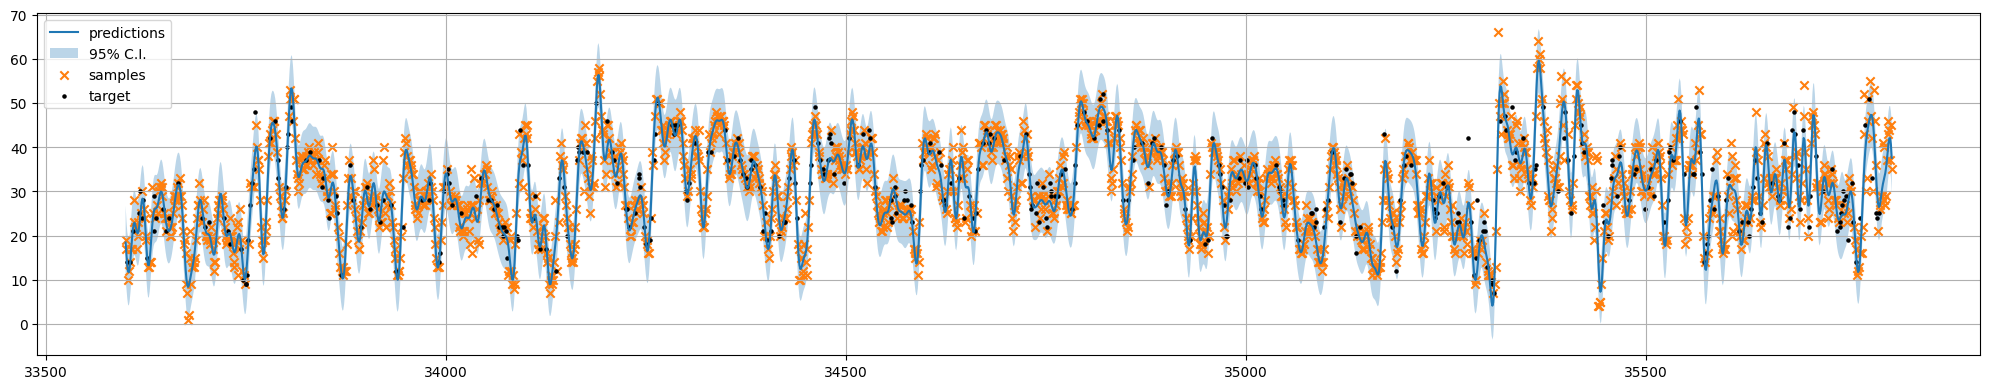

In [ ]:
plot_gp(target_samples=test_data['Value'], samples=train_data['Value'], pred=pred, std=std, figsize=figsize)

In [16]:
# Obtain predictions for the validation data
pred_ts = pred[test_data.index]
std_ts = std[test_data.index]

ldens = norm.logpdf(test_data['Value'], pred_ts, std_ts)
ll = np.sum(ldens)
print(f'Log likelihood of the validation set: {ll:.2f}')

Log likelihood of the validation set: -1081.20


#### Second Kernel

In [82]:
kernel = WhiteKernel(1e-3, (1e-4, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e3)) * RBF(1, (1e-1, 1e1))
kernel += ConstantKernel(1, (1e-2, 1e3)) * ExpSineSquared(1, 2000, (1e-1, 1e1), (900, 2100))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(train_data[['Date_idx']], train_data['Value'])
print(gp.kernel_)

WhiteKernel(noise_level=2.51) + 6.67**2 * RBF(length_scale=1.68) + 11**2 * ExpSineSquared(length_scale=9.62, periodicity=1.03e+03)


In [83]:
pred, std = gp.predict(segment[['Date_idx']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

Log likelihood of the validation set: -966.11


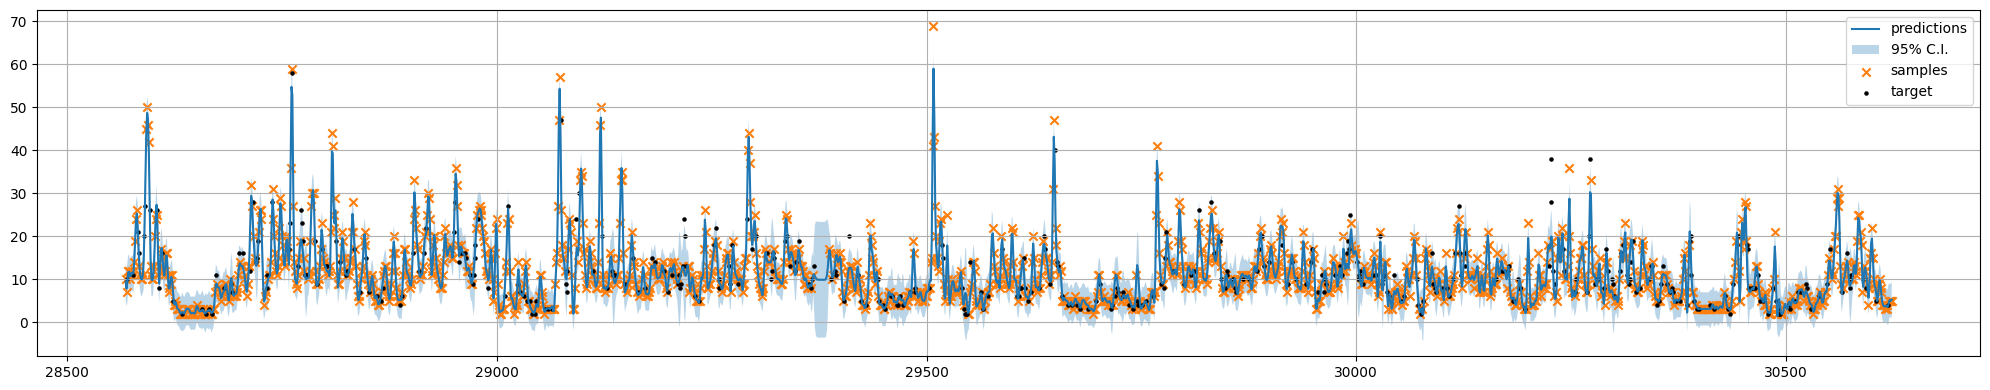

In [84]:
plot_gp(target_samples=test_data['Value'], samples=train_data['Value'], pred=pred, std=std, figsize=figsize)
ldens = norm.logpdf(test_data['Value'], pred[test_data.index], std[test_data.index])
print(f'Log likelihood of the validation set: {np.sum(ldens):.2f}')

#### sezione strana sulla std

#### Full data filling

***NOTE** : just NO2*

In [85]:
start_date=datetime(2022,3,20)
end_date=datetime(2022,4,30)

no2_df = resampled_giardini_df[(resampled_giardini_df['Agent']=='NO2')&(resampled_giardini_df['Date']>=start_date)&(resampled_giardini_df['Date']<=end_date)]
len(no2_df)

985

In [86]:
gp2 = GaussianProcessRegressor(kernel=gp.kernel_, optimizer=None)
tmp = no2_df.dropna() # The whole series (NaNs excluded)
gp2.fit(tmp[['Date_idx']], tmp['Value'])
pred_all, std_all = gp2.predict(no2_df[['Date_idx']], return_std=True)
pred_all = pd.Series(index=no2_df.index, data=pred_all)
std_all = pd.Series(index=no2_df.index, data=std_all)

predictions :(

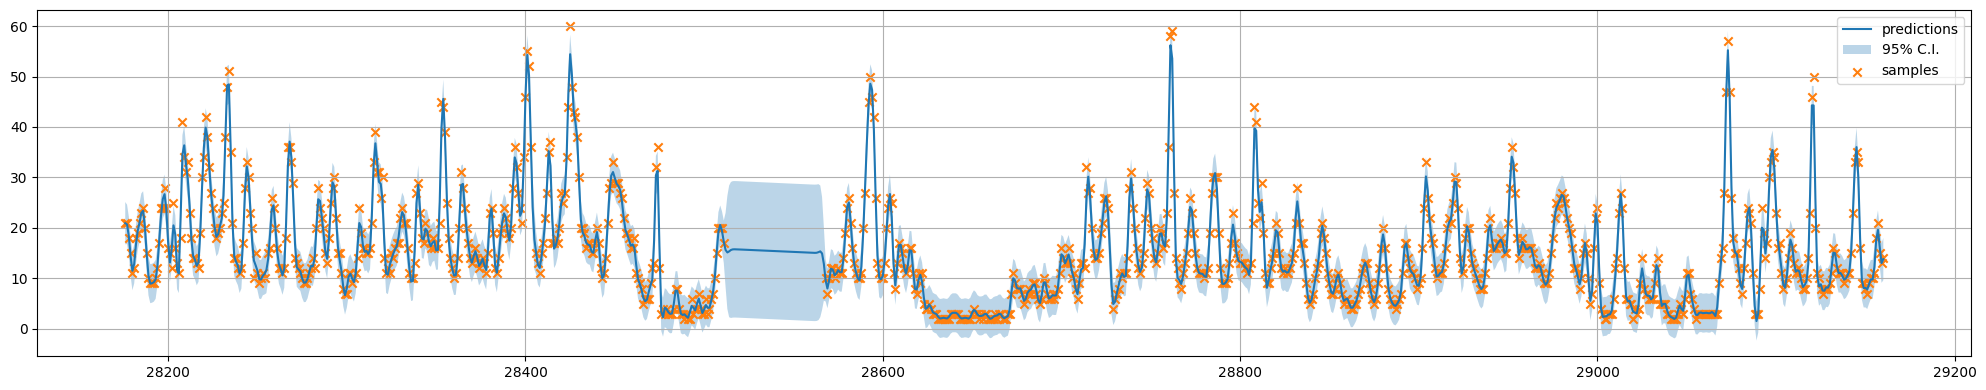

In [87]:
plot_gp(samples=no2_df['Value'], pred=pred_all, std=std_all, figsize=figsize)

### Final Function

In [ ]:
model = {
    
}

filled_giardini_df = fill_missing_dates_on_column_value(resampled_giardini_df, column_to_fill='Value', mode='model', model_settings=model)
filled_giardini_df.isna().sum()

In [ ]:
agent_dfs = df_to_agents_dict(filled_giardini_df)

Splitting station "GIARDINI MARGHERITA"...
